## Mode of Simulation 

Three type of simulation 

<strong>1. Profit maximization</strong> 

<strong>2. Solo Rides</strong>

<strong>3. Pooled Rides</strong>

## Load ExMAS and MaaSSim

In [353]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
#from MaaSSim.performance import kpi_pax_pricing
#from MaaSSim.performance import kpi_veh_pricing


import logging
import matplotlib.pyplot as plt


import pandas as pd
import ExMAS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Delft, Netherlands

In [354]:
params = get_config('../../data/config/delft.json')  # load configuration

params.times.pickup_patience = 180# 1 hour of simulation
params.times.patience = 180
params.simTime = 4 # 6 minutes hour of simulation
params.nP = 500 # reuqests (and passengers)
params.nV = 50 # vehicles


## Parameters for ExMAS

In [355]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.25
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_veh' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.0005
params.shareability.comm_rate = 0.2 

#params.platforms.comm_rate = 0.2 
#params.shareability.comm_rate = float(0.30)

inData = load_G(inData, params)  # load network graph 

inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True


# params.kpi = 1 (Profit Maximazation)
# params.kpi = 2 (Solo Rides)
# params.kpi = 3 (Pooled Rides)

In [356]:
params.kpi = 2

In [357]:
#inData = ExMAS.main(inData, params.shareability) # create shareability graph (ExMAS) 
inData = ExMAS.main(inData, params.shareability, plot = False)

15-08-23 12:51:46-INFO-Initializing pairwise trip shareability between 500 and 500 trips.
15-08-23 12:51:46-INFO-creating combinations
15-08-23 12:51:46-INFO-249500	 nR*(nR-1)
15-08-23 12:51:50-INFO-Reduction of feasible pairs by 99.83%
15-08-23 12:51:50-INFO-Degree 2 	Completed
15-08-23 12:51:50-INFO-trips to extend at degree 2 : 1047
15-08-23 12:51:51-INFO-At degree 2 feasible extensions found out of 85 searched
15-08-23 12:51:51-INFO-Degree 3 	Completed
15-08-23 12:51:51-INFO-trips to extend at degree 3 : 85
15-08-23 12:51:51-INFO-At degree 3 feasible extensions found out of 1 searched
15-08-23 12:51:51-INFO-Degree 4 	Completed
15-08-23 12:51:51-INFO-Max degree reached 4
15-08-23 12:51:51-INFO-Trips still possible to extend at degree 4 : 1


In [358]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

15-08-23 12:51:51-INFO-Matching 500 trips to 1633 rides in order to min u_veh
15-08-23 12:51:52-INFO-Problem solution: Optimal. 
Total costs for single trips:        126,391 
reduced by matching to:              104,568


In [359]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],3.498000,189,1,[3.498],"[0, 189]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1552650958, 44852056]","[None, 0, 0]",node time req_id od 0 ...,189,1.89,2.83650,0.56730,2.2692
1,[1],1.345500,72,1,[1.3455],"[3, 72]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44790565, 4159110096]","[None, 1, 1]",node time req_id od 0 ...,72,0.72,1.09350,0.21870,0.8748
2,[2],7.474000,404,1,[7.473999999999999],"[36, 404]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1519889798, 44825829]","[None, 2, 2]",node time req_id od 0 ...,404,4.04,6.06000,1.21200,4.8480
3,[3],2.215000,119,1,[2.215],"[212, 119]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1608998232, 1448535909]","[None, 3, 3]",node time req_id od 0 ...,119,1.19,1.79850,0.35970,1.4388
4,[4],4.375000,236,1,[4.375],"[232, 236]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44790947, 1322498369]","[None, 4, 4]",node time req_id od 0 ...,236,2.36,3.54900,0.70980,2.8392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,"[23, 24, 39]",16.838750,776,30,"[6.4221, 3.672625, 6.744025]","[631.0, 112, 160, 94, 103, 307]","[23, 24, 39]","[24, 23, 39]",3,1628,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44884122, 2116559760, 5591082257, 15767...","[None, 23, 24, 39, 24, 23, 39]",node time req_id od 0 ...,776,7.76,10.30950,2.06190,8.2476
1629,"[36, 28, 42]",19.718625,782,30,"[8.305900000000001, 5.061275, 6.35145]","[757.5, 159, 143, 231, 92, 157]","[36, 28, 42]","[28, 36, 42]",3,1629,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 3518912644, 44838812, 44858835, 4053473...","[None, 36, 28, 42, 28, 36, 42]",node time req_id od 0 ...,782,7.82,12.38175,2.47635,9.9054
1630,"[36, 45, 57]",19.412175,843,30,"[8.5516, 4.84295, 6.017625000000001]","[823.5, 282, 167, 118, 81, 195]","[36, 45, 57]","[45, 36, 57]",3,1630,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 3518912644, 44864523, 1371031363, 42611...","[None, 36, 45, 57, 45, 36, 57]",node time req_id od 0 ...,843,8.43,12.32100,2.46420,9.8568
1631,"[205, 201, 203]",20.174450,663,32,"[9.863975, 5.1474, 5.163075]","[5763.0, 144, 56, 276, 14, 173]","[205, 201, 203]","[201, 203, 205]",3,1631,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1830058778, 1608998223, 44753493, 14364...","[None, 205, 201, 203, 201, 203, 205]",node time req_id od 0 ...,663,6.63,13.12650,2.62530,10.5012


# calculations 

In [360]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],3.498000,189,1,[3.498],"[0, 189]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1552650958, 44852056]","[None, 0, 0]",node time req_id od 0 ...,189,1.89,2.83650,0.56730,2.2692
1,[1],1.345500,72,1,[1.3455],"[3, 72]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44790565, 4159110096]","[None, 1, 1]",node time req_id od 0 ...,72,0.72,1.09350,0.21870,0.8748
2,[2],7.474000,404,1,[7.473999999999999],"[36, 404]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1519889798, 44825829]","[None, 2, 2]",node time req_id od 0 ...,404,4.04,6.06000,1.21200,4.8480
3,[3],2.215000,119,1,[2.215],"[212, 119]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 1608998232, 1448535909]","[None, 3, 3]",node time req_id od 0 ...,119,1.19,1.79850,0.35970,1.4388
4,[4],4.375000,236,1,[4.375],"[232, 236]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 44790947, 1322498369]","[None, 4, 4]",node time req_id od 0 ...,236,2.36,3.54900,0.70980,2.8392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,"[23, 24, 39]",16.838750,776,30,"[6.4221, 3.672625, 6.744025]","[631.0, 112, 160, 94, 103, 307]","[23, 24, 39]","[24, 23, 39]",3,1628,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 44884122, 2116559760, 5591082257, 15767...","[None, 23, 24, 39, 24, 23, 39]",node time req_id od 0 ...,776,7.76,10.30950,2.06190,8.2476
1629,"[36, 28, 42]",19.718625,782,30,"[8.305900000000001, 5.061275, 6.35145]","[757.5, 159, 143, 231, 92, 157]","[36, 28, 42]","[28, 36, 42]",3,1629,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 3518912644, 44838812, 44858835, 4053473...","[None, 36, 28, 42, 28, 36, 42]",node time req_id od 0 ...,782,7.82,12.38175,2.47635,9.9054
1630,"[36, 45, 57]",19.412175,843,30,"[8.5516, 4.84295, 6.017625000000001]","[823.5, 282, 167, 118, 81, 195]","[36, 45, 57]","[45, 36, 57]",3,1630,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[None, 3518912644, 44864523, 1371031363, 42611...","[None, 36, 45, 57, 45, 36, 57]",node time req_id od 0 ...,843,8.43,12.32100,2.46420,9.8568
1631,"[205, 201, 203]",20.174450,663,32,"[9.863975, 5.1474, 5.163075]","[5763.0, 144, 56, 276, 14, 173]","[205, 201, 203]","[201, 203, 205]",3,1631,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,"[None, 1830058778, 1608998223, 44753493, 14364...","[None, 205, 201, 203, 201, 203, 205]",node time req_id od 0 ...,663,6.63,13.12650,2.62530,10.5012


In [ ]:
sim = simulate(params = params, inData = inData,  logger_level = logging.CRITICAL) # simulate

15-08-23 12:52:17-INFO-Matching 500 trips to 1633 rides in order to min u_veh
15-08-23 12:52:17-INFO-Problem solution: Optimal. 
Total costs for single trips:        126,391 
reduced by matching to:              104,568
0.0005
15-08-23 12:52:45-CRITICAL-this is request 0 with [0] available rides.
15-08-23 12:52:45-CRITICAL-ride 0 available [1]
15-08-23 12:52:45-CRITICAL-this is request 0 with [0] still available rides.
15-08-23 12:52:45-CRITICAL-vehicle 1 has 1 choices
0.0005
15-08-23 12:52:45-CRITICAL-this is request 1 with [1] available rides.
15-08-23 12:52:45-CRITICAL-ride 1 available [1]
15-08-23 12:52:45-CRITICAL-this is request 1 with [1] still available rides.
15-08-23 12:52:45-CRITICAL-vehicle 24 has 1 choices
0.0005
15-08-23 12:52:45-CRITICAL-this is request 2 with [2, 1221] available rides.
15-08-23 12:52:45-CRITICAL-ride 2 available [1]
15-08-23 12:52:45-CRITICAL-ride 1221 available [1, 0]
15-08-23 12:52:45-CRITICAL-this is request 2 with [2, 1221] still available rides.
15

In [366]:
sim.res[0].pax_exp

,ACCEPTS_OFFER,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,MEETS_DRIVER_AT_PICKUP,RECEIVES_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,STARTS_DAY,IS_REJECTED_BY_VEHICLE,REJECTS_OFFER,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE,TRAVEL,WAIT,OPERATIONS,LOST_PATIENCE
pax,,,,,,,,,,,,,,,,,,
0,15.0,189.0,20.0,30.0,367.0,0.0,0.0,10.0,0,0,0,0,0,0,189.0,367.0,55.0,False
1,15.0,72.0,20.0,30.0,110.0,0.0,3.0,10.0,0,0,0,0,0,0,72.0,110.0,55.0,False
2,15.0,404.0,20.0,30.0,0.0,0.0,36.0,10.0,0,0,0,0,0,0,404.0,0.0,55.0,False
3,15.0,119.0,20.0,30.0,110.0,55.0,212.0,10.0,0,0,0,0,0,0,119.0,165.0,55.0,False
4,15.0,236.0,20.0,30.0,113.0,0.0,232.0,10.0,0,0,0,0,0,0,236.0,113.0,55.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3.0,619.0,32.0,30.0,32.0,14307.0,12.0,10.0,0,0,0,0,0,0,619.0,14339.0,43.0,False
496,15.0,100.0,35.0,30.0,0.0,14168.0,99.0,10.0,0,0,0,0,0,0,100.0,14168.0,55.0,False
497,15.0,63.0,20.0,30.0,0.0,0.0,14316.0,10.0,0,0,0,0,0,0,63.0,0.0,55.0,False


In [367]:
sim.res[0].veh_exp

,nRIDES,nREJECTED,OUT,STARTS_DAY,OPENS_APP,RECEIVES_REQUEST,ACCEPTS_REQUEST,REJECTS_REQUEST,IS_ACCEPTED_BY_TRAVELLER,IS_REJECTED_BY_TRAVELLER,...,DRIVING_TIME,DRIVING_DIST,FARE,COMMISSION,REVENUE,PICKUP_DIST,TRAVEL_DIST,OPERATING_COST,PROFIT,LOST_PATIENCE
veh,,,,,,,,,,,,,,,,,,,,,
1,19.0,0.0,False,0,0,6948.0,195.0,0,1162.0,0,...,5412.0,54.12,1.0935,0.2187,0.8748,20.46,21.18,1.0590,-0.1842,False
2,11.0,0.0,False,0,0,6540.0,105.0,0,494.0,0,...,2735.0,27.35,6.0600,1.2120,4.8480,7.45,11.49,0.5745,4.2735,False
3,14.0,0.0,False,0,0,5810.0,195.0,0,265.0,0,...,3183.0,31.83,1.7985,0.3597,1.4388,9.75,10.94,0.5470,0.8918,False
4,5.0,0.0,False,0,0,1495.0,60.0,0,102.0,0,...,1147.0,11.47,3.5490,0.7098,2.8392,2.82,5.18,0.2590,2.5802,False
5,13.0,0.0,False,0,0,10648.0,150.0,0,191.0,0,...,2751.0,27.51,3.4785,0.6957,2.7828,5.63,7.94,0.3970,2.3858,False
6,16.0,0.0,False,0,0,9717.0,150.0,0,639.0,0,...,3278.0,32.78,1.2750,0.2550,1.0200,10.18,11.03,0.5515,0.4685,False
7,20.0,0.0,False,0,0,7600.0,175.0,0,696.0,0,...,4974.0,49.74,3.9945,0.7989,3.1956,17.52,20.18,1.0090,2.1866,False
8,9.0,0.0,False,0,0,10325.0,90.0,0,304.0,0,...,2863.0,28.63,1.0215,0.2043,0.8172,10.20,10.88,0.5440,0.2732,False
9,7.0,0.0,False,0,0,12092.0,75.0,0,157.0,0,...,1455.0,14.55,3.9060,0.7812,3.1248,3.69,6.29,0.3145,2.8103,False


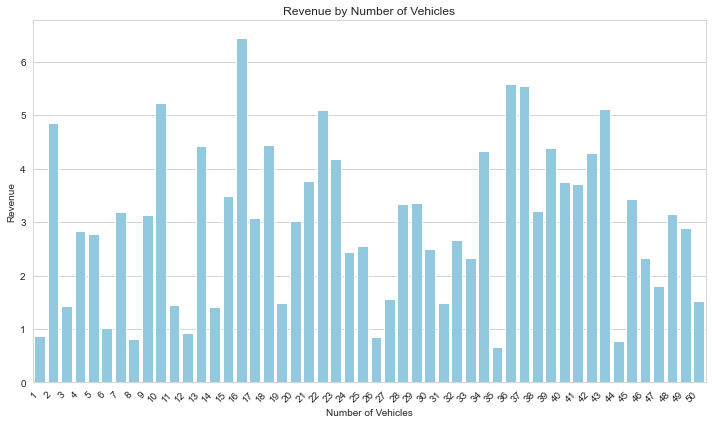

In [370]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Assuming sim, sim.res[0], and sim.res[0].veh_exp are properly defined

# Add 'Vehicles' as a column
sim.res[0].veh_exp['Vehicles'] = sim.res[0].veh_exp.index

# Set up the figure
plt.figure(figsize=(10, 6))  # Adjusted figure size

# Create the bar plot with custom bar colors
ax = sns.barplot(data=sim.res[0].veh_exp, x="Vehicles", y="REVENUE", color="skyblue")

# Add labels and title
plt.xlabel("Number of Vehicles")
plt.ylabel("Revenue")
plt.title("Revenue by Number of Vehicles")

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Adjust spacing between x-axis ticks and labels
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
sim.res[0].veh_exp.to_csv('D:/Development/GitHub-ProjectV2.0/MaaSSim/docs/tutorials/Plotting/PrivateRide1.csv')


# Service rate 

In [ ]:
Fulfilled_requests = sim.res[0].pax_exp.LOST_PATIENCE.value_counts().loc[False]
unFulfilled_requests = sim.res[0].pax_exp.LOST_PATIENCE.value_counts().loc[True]
service_rate = Fulfilled_requests/(Fulfilled_requests+unFulfilled_requests)
print('service_rate = ', service_rate*100, '%')



In [ ]:
#sim.res[0].veh_kpi.to_csv('D:/Development/GitHub-ProjectV2.0/MaaSSim/docs/tutorials/Results/Simulation/Driver/Test/veh{}.csv')
#sim.res[0].pax_kpi.to_csv('D:/Development/GitHub-ProjectV2.0/MaaSSim/docs/tutorials/Results/Simulation/Driver/Test/pax{}.csv')

In [ ]:
#for i in range(1, 2):
    #params.kpi = i
    #sim = simulate(params=params, inData = inData,  kpi_veh=kpi_veh_pricing,kpi_pax=kpi_pax_pricing, logger_level=logging.WARNING)
   # sim = simulate(params = params, inData = inData, logger_level = logging.CRITICAL) # simulate
    #sim.res[0].veh_kpi.to_csv('D:/Development/GitHub-ProjectV2.0/MaaSSim/docs/tutorials/Results/Simulation/Driver/Test/veh{}.csv'.format(i))
   # sim.res[0].pax_kpi.to_csv('D:/Development/GitHub-ProjectV2.0/MaaSSim/docs/tutorials/Results/Simulation/Driver/Test/pax{}.csv'.format(i))
   

In [ ]:
#sim.vehs[2].rdf 

In [ ]:
#pd.DataFrame(sim.vehs[2].myrides)

## Script 